# Some Basic Data Prep for Modeling
### Based on Stack Overflow Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 5000)

df0 = pd.read_csv('./survey_results_public.csv')
df_schema = pd.read_csv('./survey_results_schema.csv')

In [2]:
def cleaning_function(df):
    '''
    INPUT: Raw dataframe from stack exchange
    
    OUTPUT: Dataframe cleaned in an appropriate manner for future
            analysis. Some data points might be excluded or columns
            transformed.
    '''
#     current analysis focused on us working population
    df = df[(
        df.EmploymentStatus.ne('Not employed, and not looking for work')&
        df.EmploymentStatus.ne('Not employed, but looking for work')&
        df.EmploymentStatus.ne('Retired')&
        df.Country.eq('United States')
        )] 
    
#     drop if JobSatisfaction outcomes is missing this is the 
#     outcome of interest
    df = df.loc[df['JobSatisfaction'].isnull() == False, :]
#     Only 6 missing values going to drop the nulls here for ease 
#     since its the Ind Var we want to interpret I don't want to guess/
#     estimate/impute this one in this exercise
    df = df.loc[df['HomeRemote'].isnull() == False, :]
    
    return df
    

In [3]:
df = cleaning_function(df0)

In [488]:
# #For Visual detailed inspection of variables to see how answers
# #are structured on the survey

# for col_name in enumerate(df.columns[1:(len(df.columns)-1)]):
    
#     unique_values = len(df[col_name[1]].unique())
#     missing = df[col_name[1]].isnull().sum()
    
#     print('{} values in ***{}*** ({} missing)'
#           .format(unique_values, col_name[1], missing))
# #     print('QUESTION: ',df_schema.iloc[col_name[0],1])
# #     for i in range(unique_values):
# #         print(df[col_name[1]].unique()[i])
# #         print('====')
# #     print(df[col_name[1]].unique())
#     print('-----------')

##### After Visual Inspection

think about including:

    - AsessJobRemote what are the pros and cons of leaving this out
    - CollaborateRemote
    
exclude: 

    - country

modify/research: 

    - (hours per week /Salary/ExpectedSalary) 
        needs to be dummied there is too many missing values
        do some research on it and think of a way to bucket
    - need to condense DeveloperType before dummy
    - ImportantBenefits: need to condense or drop (there is also 
        remote) options in this variable - maybe break down 
        the individual dummies and also how many options were 
        selected as an engineered feature
    - job profile: consider the same as importantBenefits
    - EducationTypes: same as above
    - SelfTaughtTypes same as above
    - CousinEducation same as above
    - HaveWorkedLanguage
    - WantWorkLanguage
    - HaveWorkedFramework
    - WantWorkFramework
    - HaveWorkedDatabase
    - WantWorkDatabase
    - Have/Want Work Platform
    - IDE
    - Methodology
    - MetricAssess
    - StackOverflowDevices
    - Gender
    - Race
    
keep the same:

    - Categoricals with less than 25 categories

I want to be able to say something for how an increase in remote working can influence a workers job satisfaction. This will be less a prediction task and more an inference task. I like using linear regression for these tasks because of the ease of interpretability. 

If we broke each column out into dummy variables we would have more columns then rows and using linear regression would not be appropriate. I like the 10:1 variable to observation rule which means we should look to include no more than about 36 variables as controls.

Steps and notes:

- Step1: see if there is a way to collapse some columns. After inspection there are 2 columns that are numeric that I want to bucket that will need inspection (HoursPerWeek/Salary. There are some categoricals with multiple answers I will find the unique values and condense the dummy columns into less granular columns which could help reduce the feature space.
- Step2: Create a variable importance to help sort through the variables and help chose the best n variables. remember we will be creating dummy variables for home remote status because that is the independent variable of interest. There are 7 categories and we need to drop 1 for interpretation (Never) which means max were going to use 30 other columns

I will start with the 3 numeric columns I need to bucket: HoursPerWeek, Salary. Here I show Visual inspection of the data to get close to even categories in HoursPerWeek. I applied the same process to the other 2 columns.

### Working with Numerics that need to be binned

In [71]:
def numeric_viewer(df, col_string):
    print(
        list(
            df_schema[
                df_schema
                .Column
                .eq(col_string)]['Question']))
    print('\nColumn Stats \n\n', df[col_string].describe())
    
    df[col_string].plot(kind='hist');

['During a typical week, approximately how many hours do you spend on activities related to finding new job opportunities?Please adjust the slider to the appropriate number of hours. The box to the right will indicate the number of hours you have chosen.']

Column Stats 

 count    1422.000000
mean        2.769339
std         5.623937
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        40.000000
Name: HoursPerWeek, dtype: float64

 Cumulative Distribution

 0.0     0.119034
 1.0     0.231687
 2.0     0.293285
 3.0     0.314095
 4.0     0.334073
 5.0     0.352109
 6.0     0.358491
 7.0     0.361265
 8.0     0.367647
 9.0     0.368479
 10.0    0.377636
 11.0    0.378746
 12.0    0.380411
 13.0    0.381521
 15.0    0.383185
 18.0    0.383463
 20.0    0.387347
 21.0    0.387902
 23.0    0.388457
 30.0    0.388735
 32.0    0.389012
 38.0    0.389567
 39.0    0.389845
 40.0    0.394562
NaN      1.000000
Name: HoursPerWeek, dtype: float64


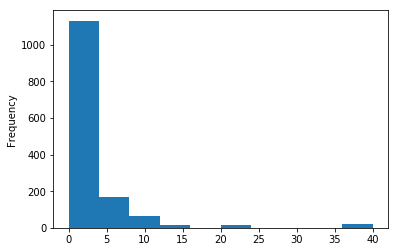

In [87]:
numeric_viewer(df, 'HoursPerWeek')
print('\n Cumulative Distribution\n')
print((round(df['HoursPerWeek'], -0)
       .value_counts(dropna=False)/df['HoursPerWeek']
       .shape[0])
      .sort_index()
      .cumsum())

### Collapsing variables into less columns

The data we were given on some of the variables had multiple repsonses that were vary granular. For instance there might be only 1 person in the data set that was a Developer/Data Scientist/Pick any other of 12 attirbutes. Having dummy variables for each and every possible outcome is a great way to not only add too many variables but to overfit as well. I was able to extract each unique value from the entire set and give each person a value if they mentioned that category. In doing this we reduced the number of categories of the DeveloperType from 440 down to only 14 and kept all the user information! Here is how I arrived at being able to do that. This will be passed into the cleaning_function and will loop over all the columns I want to collapse listed above and return a similar set for each.

In [377]:
# Here is an example of the first 10 users from the dataset
# notice for index #17 there are multiple indicators for 
# developer type. In the original datset these are just stacked
# together in a single column as multiple values which makes the
# data extremely granular.


a = df['DeveloperType'].head(10)
a = a.str.split(';')
b = list()
for i in range(len(a)):
#     print(i)
#     print(a.iloc[i])
#     print(type(a.iloc[i]))
    if type(a.iloc[i]) == float:
        next
#         print('heres a float')
    else:
#         print(a.iloc[i])
        for j in range(len(a.iloc[i])):
#             print(a.iloc[i][j])
            b.append(a.iloc[i][j].strip())
unique_cats = list(np.unique(b))

dummy_df = pd.DataFrame(index=np.arange(0,len(a),1))
for j in range(len(unique_cats)):
    d = list()
    for i in range(len(a)):
        if type(a.iloc[i]) == float:
            d.append(0)
        else:
            is_in = str(unique_cats[j]) in ''.join(a.iloc[i]) 
            d.append(int(is_in))
    dummy_df = pd.merge(dummy_df, 
                        pd.DataFrame(d, columns=[unique_cats[j]]), 
                        right_index=True, 
                        left_index=True)
    
    
dummy_df.index = a.index
dummy_df

,Desktop applications developer,DevOps specialist,Embedded applications/devices developer,Other,Quality assurance engineer,Web developer
3,0,0,0,0,0,0
6,0,0,0,0,0,0
10,0,0,0,0,0,0
15,1,0,0,0,0,0
17,0,1,1,1,1,1
18,0,0,0,0,0,1
25,0,0,0,0,0,1
27,1,0,0,0,0,1
29,0,0,0,0,0,0
39,1,0,0,0,0,0


CareerSatisfaction           float64
StackOverflowSatisfaction    float64
dtype: object

In [15]:
# Cleaning function to help preprocess data

def cleaning_function(df):
    '''
    INPUT: Raw dataframe from stack exchange (2017)
    
    OUTPUT: Dataframe cleaned in an appropriate manner for future
            analysis. Some data points might be excluded or columns
            transformed. Categoricals with <25 categories are left
            as is while >25 are condensed to include less categories.
    '''
    original_shape = df.shape
#     current analysis focused on us working population
    df = df[(
        df.EmploymentStatus.ne('Not employed, and not looking for work')&
        df.EmploymentStatus.ne('Not employed, but looking for work')&
        df.EmploymentStatus.ne('Retired')&
        df.Country.eq('United States')
        )] 
    df.drop(['Country'], axis=1, inplace=True)
    
#     drop if JobSatisfaction outcomes is missing this is the 
#     outcome of interest
    df = df[pd.notnull(df.JobSatisfaction)]
    
#     Only 6 missing values going to drop the nulls here for ease 
#     since its the Ind Var we want to interpret I don't want to guess/
#     estimate/impute this one in this exercise
    df = df[pd.notnull(df.HomeRemote)]
    
    #Bin certain numberics
    hours_per_week = pd.cut(df['HoursPerWeek'], 
                            [0,1,2,6,20,41],
                            labels=['0', '1', '2-5', '6-20', '20+'],
                            right=False)
    hours_per_week = pd.get_dummies(hours_per_week,
                                    prefix='HoursPerWeek',
                                    prefix_sep='=',
                                    dummy_na=False)
    salary = pd.cut(df['Salary'],
                    [0,75000,100000,150000,300000],
                    labels=['<75k', '75-99k', '100-149k', '150k+'],
                    right=False)
    salary = pd.get_dummies(salary, 
                            prefix='Salary',
                            prefix_sep='=', 
                            dummy_na=False)
    
    #Select unaffected numerica columns
    numeric_cols = df['JobSatisfaction']
    
    #Collapsing multi-select categoricals
    cols_to_replace = [
        'DeveloperType','ImportantBenefits','JobProfile',
        'EducationTypes','SelfTaughtTypes','CousinEducation', 
        'HaveWorkedLanguage','WantWorkLanguage','HaveWorkedFramework',
        'WantWorkFramework','HaveWorkedDatabase','WantWorkDatabase',
        'HaveWorkedPlatform','WantWorkPlatform','IDE','Methodology',
        'MetricAssess','StackOverflowDevices','Gender','Race']
    
    master_df = pd.DataFrame(index=np.arange(0,df.shape[0],1))
    for k in range(len(cols_to_replace)):
        a = df[cols_to_replace[k]]
        a = a.str.split(';')
        b = list()
        for i in range(len(a)):
            if type(a.iloc[i]) == float:
                next
            else:
                for j in range(len(a.iloc[i])):
                    b.append(a.iloc[i][j].strip())

        unique_cats = list(np.unique(b))

        dummy_df = pd.DataFrame(index=np.arange(0,len(a),1))
        for j in range(len(unique_cats)):
            d = list()
            for i in range(len(a)):
                if type(a.iloc[i]) == float:
                    d.append(0)
                else:
                    is_in = str(unique_cats[j]) in ''.join(a.iloc[i]) 
                    d.append(int(is_in))

            column_names = [cols_to_replace[k] + '=' + unique_cats[j]]
            dummy_df = pd.merge(dummy_df, 
                                pd.DataFrame(d, columns=column_names), 
                                right_index=True, left_index=True)

        master_df = pd.merge(master_df, dummy_df, 
                             right_index=True,left_index=True)

    master_df.index = df.index

    #Create a list of categoricals that will be converted to 
    #simple dummy varabies with no alteration and then convet
    keep_same = list()
    for col_name in enumerate(df.columns):

        unique_values = len(df[col_name[1]].unique())
        data_type = df.dtypes[col_name[0]]

        cols_to_replace = [
            'DeveloperType','ImportantBenefits','JobProfile',
            'EducationTypes','SelfTaughtTypes','CousinEducation', 
            'HaveWorkedLanguage','WantWorkLanguage','HaveWorkedFramework',
            'WantWorkFramework','HaveWorkedDatabase','WantWorkDatabase',
            'HaveWorkedPlatform','WantWorkPlatform','IDE','Methodology',
            'MetricAssess','StackOverflowDevices','Gender','Race',
            'CareerSatisfaction', 'StackOverflowSatisfaction']
        exclude_these = ['HomeRemote', 'HoursPerWeek', 'Country']

        if (unique_values < 26 
                and data_type == 'object' 
                and col_name[1] not in cols_to_replace
                and col_name[1] not in exclude_these): 
            keep_same.append(col_name[1])
    
    unchanged_dummy = pd.get_dummies(df[keep_same],
                                     prefix_sep='=',
                                     dummy_na=False)
    
    #Target columns get special treatment
    new_homeRemote_names = {
    'Less than half the time, but at least one day each week': 
        'Remote=1PlusDaysPerWeek',
    "All or almost all the time (I'm full-time remote)": 
        'Remote=FullTime',
    'A few days each month': 'Remote=FewDaysPerMonth',
    'More than half, but not all, the time': 'Remote=MoreThanHalf',
    'Never': 'Remote=Never',
    "It's complicated": 'Remote=ItsComplicated',
    'About half the time': 'Remote=HalfTime'
    }

    homeRemote = (pd
                  .get_dummies(df['HomeRemote'])
                  .rename(columns=new_homeRemote_names))

    #Merge DataFrames on Index
    df2 = pd.DataFrame(numeric_cols).merge(pd.DataFrame(hours_per_week), 
                             left_index=True, right_index=True)
    df2 = df2.merge(homeRemote, 
                    left_index=True, right_index=True)
    df2 = df2.merge(pd.DataFrame(salary),
                    left_index=True,right_index=True)
    df2 = df2.merge(master_df, 
                    left_index=True, right_index=True)
    df2 = df2.merge(unchanged_dummy, 
                    left_index=True, right_index=True)
    print('\nTransformation Overview:\n'
          'Original dataframe dimension were {0}\n'
          'New dataframe dimension are {1}'
          .format(original_shape, df2.shape))
    return df2

In [ ]:
cleaning_function(df0).head()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
